In [42]:
import pandas as pd
import matplotlib.pyplot as plt

Pre-processing

First we take a high-level look at the data. As you can see from the description, there are two columns that have so many missing values that they are unusable - for this reason we drop the "license" and "square_feet" columns. The price column is of type string, we convert this into a numerical column.

In [43]:
#Pre-processing

#Read in Seattle AirBnB listings data
df = pd.read_csv('listings.csv')

#overview of data
print(df.head())

#Convert price column to numerical
df['price'] = pd.to_numeric(df['price'].str.replace('$','').str.replace(',',''))

#Descriptive stats of dataset
descr = df.describe()

print(descr)

#Drop columns that have most or all NaN values
df = df.drop(['license', 'square_feet'], axis=1)

        id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits at

C:\Users\Hashim\AppData\Local\Temp\ipykernel_9348\1167955942.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = pd.to_numeric(df['price'].str.replace('$','').str.replace(',',''))


Further pre-processing

We can see that there are a few columns that have binary values in the form of 't' and 'f'. We must convert these over to numerical binary values 1 or 0.

In [44]:
#Find the names of all columns that have 't' or 'f' true/false values and put them in cat_col_names
cat_col_names = []
for col in df.columns:
    if df.loc[0,col] in ['t','f']:
        cat_col_names.append(col)

#Convert columns with true or false values to 1 or 0 numerical instead
for cat_col_name in cat_col_names:
    cat_col = list(df[cat_col_name])
    
    for i, val in enumerate(cat_col):
        if val == 't':
            cat_col[i] = 1
        elif val == 'f':
            cat_col[i] = 0
        else:
            cat_col[i] = 0.5
            
    df[cat_col_name] = cat_col
    
    
#Descriptive stats of dataset
descr_2 = df.describe()
print(descr_2)

                 id     scrape_id       host_id  host_is_superhost  \
count  3.818000e+03  3.818000e+03  3.818000e+03        3818.000000   
mean   5.550111e+06  2.016010e+13  1.578556e+07           0.204034   
std    2.962660e+06  0.000000e+00  1.458382e+07           0.402884   
min    3.335000e+03  2.016010e+13  4.193000e+03           0.000000   
25%    3.258256e+06  2.016010e+13  3.275204e+06           0.000000   
50%    6.118244e+06  2.016010e+13  1.055814e+07           0.000000   
75%    8.035127e+06  2.016010e+13  2.590309e+07           0.000000   
max    1.034016e+07  2.016010e+13  5.320861e+07           1.000000   

       host_listings_count  host_total_listings_count  host_has_profile_pic  \
count          3816.000000                3816.000000           3818.000000   
mean              7.157757                   7.157757              0.997905   
std              28.628149                  28.628149              0.044278   
min               1.000000                   1.000000

Question #1: Which neighborhoods do AirBnB guests in Seattle prefer?

To answer this we will look at the mean and median prices for AirBnB listings in various Seattle neighborhoods.

In [45]:
#Get mean and median price by neighborhood
price_mean_by_n = df.groupby(['neighbourhood_group_cleansed'])['price'].mean()
price_median_by_n = df.groupby(['neighbourhood_group_cleansed'])['price'].median()

In [46]:
#Create dataframe of mean and median prices by neighborhood
price_by_n = pd.concat([price_mean_by_n, price_median_by_n], axis=1)
price_by_n.columns = ['Mean','Median']
price_by_n = price_by_n.sort_values(by='Median', ascending=False)

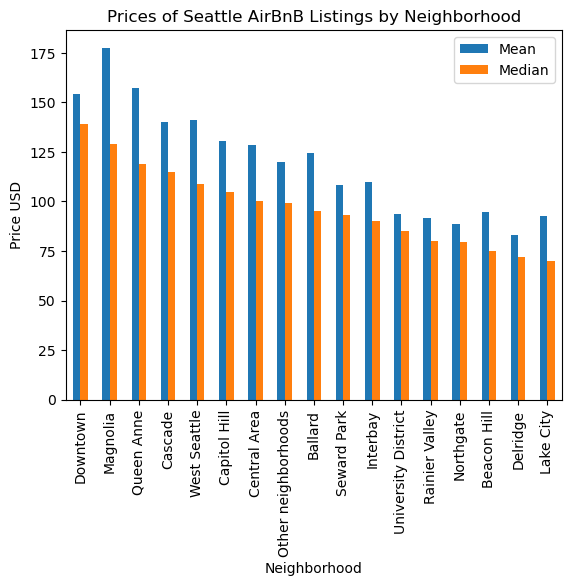

<Figure size 640x480 with 0 Axes>

In [47]:
#Plot
price_by_n.plot(kind="bar")
plt.title("Prices of Seattle AirBnB Listings by Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Price USD")
plt.figure().clear()

Question #2: What are the top factors that impact the overall review score of a listing?

To answer this question, we create a correlation matrix of all the variables in the dataset. From this matrix, we can isolate just the overall review score variable and then rank the remaining variables to determine which have the largest impact on overall revie score.

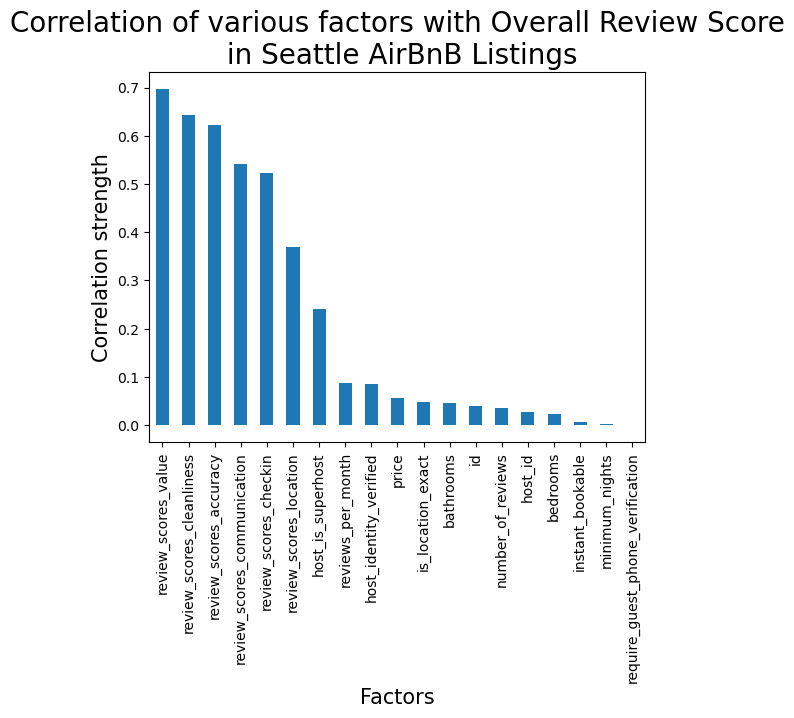

<Figure size 640x480 with 0 Axes>

In [48]:
#correlation matrix, isolate for overall review score
cor = df.corr()['review_scores_rating'].sort_values(ascending=False)[1:20]

#Plot as bar chart
cor.plot(kind = 'bar')
plt.xlabel("Factors",  size = 15)
plt.ylabel("Correlation strength", size = 15)
plt.title("Correlation of various factors with Overall Review Score\n in Seattle AirBnB Listings", size = 20)
plt.figure().clear()

Question #3: Which factors are associated with higher listing prices?

In order to answer this question we will create a correlation matrix to determine the strength of the relation of various factors (including amenities) to the price. However, in the dataset there is a single column for amenities in which the amenities are listed out for each property. To work around this, we will convert this column of lists to dummy columns for each amenity where the value of that amenity will be 1 if the property has it and 0 otherwise.

In [49]:
def lists_to_columns(amenities):
    """Convert a column of lists of amenities to a dataframe with dummy columns for each item

    Args:
        amenities (list): list in which each element of the list is a list of amenities for one AirBnB property

    Returns:
        Dataframe: dataframe with dummy variables for 
    """
    master_str = ''
    for i, listing in enumerate(amenities):
        listing = listing.replace('"','').replace('{',',').replace('}','')
        master_str = master_str + listing
        amenities[i] = listing[1:]
    master_set = list(set(master_str.split(',')[1:]))[1:]
    
    df_amen_data = []
    for i, listing in enumerate(amenities):
        new_row = []
        for x, amen in enumerate(master_set):
            if amen in listing:
                new_row.append(1)
            else:
                new_row.append(0)
        df_amen_data.append(new_row)
    return pd.DataFrame(df_amen_data, columns = master_set)

In [50]:
#Create a new dataframe with a dummy column for each amenity, then combine new df with existing dataframe
df_amen = lists_to_columns(list(df['amenities']))
df_final = pd.concat([df, df_amen], axis=1)

In [51]:
#Create correlation matrix of new dataframe and isolate price column
cor_final = df_final.corr()['price'].sort_values(ascending=False)[1:20]

Text(0.5, 1.0, 'Correlation of various factors with Price\n of Seattle AirBnB Listings')

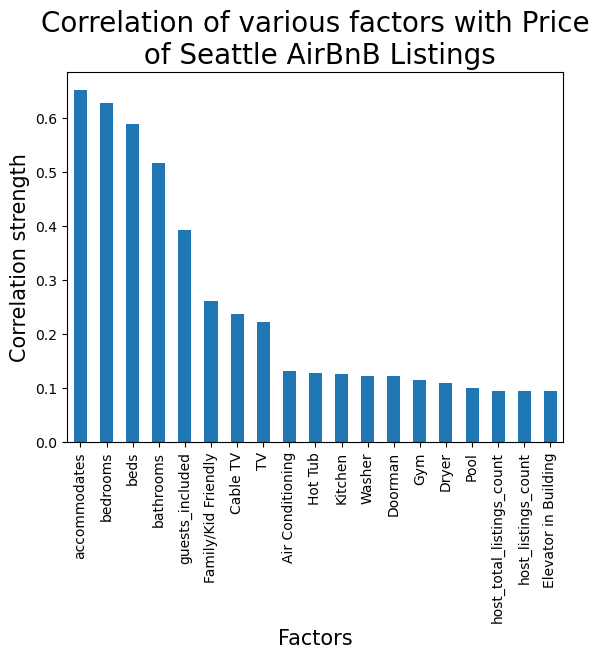

In [52]:
#Plot
cor_final.plot(kind = 'bar')
plt.xlabel("Factors",  size = 15)
plt.ylabel("Correlation strength", size = 15)
plt.title("Correlation of various factors with Price\n of Seattle AirBnB Listings", size = 20)